In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.types import *
import pandas as pd
import databricks.koalas as ks
import os, shutil
import numpy as np
import matplotlib.pyplot as pl


spark = SparkSession.builder \
        .master('local[3]') \
        .appName('OPI_Analytics') \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:0.7.0") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config('spark.executor.memory','12gb') \
        .getOrCreate()

sc = spark.sparkContext
spark.sql("set spark.sql.shuffle.partitions = 4")


DataFrame[key: string, value: string]

# NOTA IMPORTANTE. descargar el archivo la carpeta llamada "DeltaData" y colocarla en el mismo directorio de donde se ejecute este Notebook.
el link de descarga del archivo es el sig: 'https://1drv.ms/u/s!As4zvXVPTtlMllc5rvp0wQFydDm_?e=jboiaN'
También se debe de tomar en cuenta que para que este Notebook funcione se debe de tener actualizado spark y PySpark a la última version (version 3.0.1), e instalar las dependencias
del formato Delta.

La razón por la que se utilizó el formato Delta fue por que el archivo cvs original pesaba alrededor de 20 GB, y en cambio con el formato Delta solo pesa aprox. 780 mb, aparte de que dicho formato está optimizado para lectura y escritura en Spark, permite una versión de control para los datos y asegura que todas las actualizaciones queden en un mismo tipo de esquema.

In [2]:
delta_path = "DeltaData/"
spark.read.format("delta").load(delta_path).createOrReplaceTempView("preciosProfeco")

# 1. Procesamiento de los datos

## ¿Cuántos registros hay?

In [15]:

num_registros = spark.sql("SELECT COUNT(*) FROM preciosProfeco")
num_registros.show()

+--------+
|count(1)|
+--------+
|62530715|
+--------+



## ¿Cuántas categorías? R: 41

In [17]:
num_categorias = spark.sql("SELECT COUNT(DISTINCT categoria) FROM preciosProfeco")
num_categorias.show()

+-------------------------+
|count(DISTINCT categoria)|
+-------------------------+
|                       41|
+-------------------------+



## ¿Cuántas cadenas comerciales están siendo monitoreadas? R: 705

In [19]:
num_cadenas_com = spark.sql("SELECT COUNT(DISTINCT cadenaComercial) FROM preciosProfeco")
num_cadenas_com.show()

+-------------------------------+
|count(DISTINCT cadenaComercial)|
+-------------------------------+
|                            705|
+-------------------------------+



## ¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de inconsistencia o error en la fuente?

Se podría iniciar con una resumen descriptivo para c/u de las columnas, ver sus valores máximos y mínimos para detectar valores extremos y también si es que tienen NA's. En este caso los datos presentan errores e inconsistencias en los nombres de las entidades y de los municipios, la información de productos, y también hay datos faltantes.

In [4]:
stats = spark.sql("SELECT * FROM preciosProfeco")
stats.describe().show(10)

KeyboardInterrupt: 

## ¿Cuáles son los productos más monitoreados en cada entidad?

R: se hace un conteo del número de filas (mayor presencia del producto) que tiene cada combinación estado/producto y se ordenan de mayor a menor. En este caso solo se muestra el top 5 de productos para cada estado. Hay que tener en cuenta que debido a la premura del tiempo no se hizo una limpieza de datos en el nombre de los estados y por eso aparecen casos que no corresponden a los estados (ej. hay estados registrados con nombre de calles particulares)

In [10]:
stats = spark.sql(" SELECT DISTINCT producto, estado, ROW_NUMBER() OVER (PARTITION BY estado, producto ORDER BY producto, estado DESC) AS num_monitor FROM preciosProfeco WHERE estado IS NOT NULL" )
stats.createOrReplaceTempView('productosPopulares')

spark.sql('SELECT DISTINCT * FROM productosPopulares WHERE num_monitor <= 5 ORDER BY estado DESC').show(10)


+--------+---------+-----------+
|producto|   estado|num_monitor|
+--------+---------+-----------+
|producto|   estado|          4|
|producto|   estado|          3|
|producto|   estado|          1|
|producto|   estado|          2|
|producto|   estado|          5|
|ACEITUNA|ZACATECAS|          3|
|  ACEITE|ZACATECAS|          4|
|  ACEITE|ZACATECAS|          2|
|ACEITUNA|ZACATECAS|          4|
|  ACEITE|ZACATECAS|          5|
+--------+---------+-----------+
only showing top 10 rows



## ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados? 

R: Soriana, ya que se contó el número de productos distintos que maneja cada cadena Comercial

In [9]:
tienda = spark.sql("SELECT cadenaComercial, COUNT(DISTINCT producto) AS num_prods FROM preciosProfeco GROUP BY cadenaComercial ORDER BY num_prods DESC")
tienda.show()

+--------------------+---------+
|     cadenaComercial|num_prods|
+--------------------+---------+
|             SORIANA|     1059|
|            WAL-MART|     1051|
|MEGA COMERCIAL ME...|     1049|
|  COMERCIAL MEXICANA|     1036|
|            CHEDRAUI|     1026|
|     MERCADO SORIANA|     1024|
|      BODEGA AURRERA|     1012|
|HIPERMERCADO SORIANA|     1006|
|              H.E.B.|     1001|
|        SORIANA PLUS|      999|
|       SORIANA SUPER|      996|
|BODEGA COMERCIAL ...|      979|
|        I.S.S.S.T.E.|      937|
|            SUPERAMA|      936|
|              S MART|      851|
|SUPERMERCADOS SAN...|      849|
|              SUMESA|      848|
|         CITY MARKET|      844|
|FARMACIA GUADALAJARA|      819|
|            CASA LEY|      808|
+--------------------+---------+
only showing top 20 rows



# Análisis exploratorio

## Genera una canasta de productos básicos que te permita comparar los precios geográfica y temporalmente. Justifica tu elección y procedimiento

R: Primero debemos de seleccionar los 10 productos más vendidos para después comparar temporal y geográficamente dichos productos

In [11]:
canasta = spark.sql("SELECT DISTINCT producto, COUNT(producto) AS num_ventas FROM preciosProfeco GROUP BY producto ORDER BY num_ventas DESC LIMIT 10")
canasta.show()

+--------------------+----------+
|            producto|num_ventas|
+--------------------+----------+
|            REFRESCO|   1247981|
|   DETERGENTE P/ROPA|    990122|
|                 FUD|    933410|
|LECHE ULTRAPASTEU...|    886716|
|             SHAMPOO|    745467|
|    JABON DE TOCADOR|    744914|
|      CHILES EN LATA|    724862|
|            MAYONESA|    697586|
|             YOGHURT|    632362|
|         DESODORANTE|    623684|
+--------------------+----------+



## ¿Cuál es la ciudad más cara del país? ¿Cuál es la más barata?
R: la ciudad más cara sería Huixquilucan y la más barata Tlajomulco de zuñiga. El criterio de evaluación fue obtener los precios promedios para cada combinación producto/ciudad , tomando en cuenta solo los 10 productos de la canasta previamente calculada. Después se calculo el valor del precio máximo/mínimo de un ticket ficticio que solo tuviera 1 compra de cada producto, tomando en cuenta solo los precios mínimos/máximos.

In [37]:
precios_max = spark.sql("SELECT DISTINCT municipio, producto, AVG(precio) OVER (PARTITION BY municipio, producto) AS precio_max FROM preciosProfeco WHERE producto IN ('REFRESCO', 'DETERGENTE P/ROPA', 'FUD', 'LECHE ULTRAPASTEURIZADA', 'SHAMPOO', 'JABON DE TOCADOR', 'CHILES EN LATA', 'MAYONESA', 'YOGHURT', 'DESODORANTE') ORDER BY precio_max DESC ")
precios_max.createOrReplaceTempView("preciosMax")

precios_min = spark.sql("SELECT DISTINCT municipio, producto, AVG(precio) OVER (PARTITION BY municipio, producto) AS precio_min FROM preciosProfeco WHERE producto IN ('REFRESCO', 'DETERGENTE P/ROPA', 'FUD', 'LECHE ULTRAPASTEURIZADA', 'SHAMPOO', 'JABON DE TOCADOR', 'CHILES EN LATA', 'MAYONESA', 'YOGHURT', 'DESODORANTE') ORDER BY precio_min ASC ")
precios_min.createOrReplaceTempView("preciosMin")

ciudad_cara = spark.sql("SELECT DISTINCT municipio, SUM(precio_max) OVER (PARTITION BY municipio) AS compra_max FROM preciosMax ORDER BY compra_max DESC")
ciudad_cara.show()

ciudad_barata = spark.sql("SELECT DISTINCT municipio, SUM(precio_min) OVER (PARTITION BY municipio) AS compra_min FROM preciosMin ORDER BY compra_min ASC")
ciudad_barata.show()


+--------------------+------------------+
|           municipio|        compra_max|
+--------------------+------------------+
|        HUIXQUILUCAN| 308.6201394593532|
|         TLAQUEPAQUE| 305.1969317617744|
|SAN PEDRO GARZA G...| 305.0157198691079|
|     PACHUCA DE SOTO| 303.6125333428809|
|             URUAPAN| 301.0264287845498|
|             REYNOSA| 298.6799912817583|
|          CUAUTITLÁN| 298.5863169883927|
|              LA PAZ| 298.4957904357602|
|        BOCA DEL RÍO|298.48360765993544|
|             TIJUANA| 297.5753358081157|
|        AZCAPOTZALCO|297.28574829559534|
|      ÁLVARO OBREGÓN| 297.0257259328497|
|               TEPIC| 296.5878463520897|
|SAN NICOLÁS DE LO...|295.63344935424794|
|             TLALPAN|295.62090397880655|
|            COACALCO|294.61967668676425|
|         SOLIDARIDAD|294.61611186343237|
|               LERMA|294.13991458672876|
|             ORIZABA| 293.8371233980736|
|             ZAPOPAN|293.55630992123355|
+--------------------+------------

## ¿Hay algún patrón estacional entre años?

Suponiendo que esta pregunta esta relacionada con la anterior (observar como cambia el precio promedio de compra ) se hace el siguiente análisis de series de tiempo para el precio promedio de compras de los 10 artículos de la canasta. Se observa que en la gran mayoría de las ciudades hay una tendencia a la alza en el promedio de compra de los productos de la canasta. Dicho incremento parece ser linear con algunas excepciones (hay datos faltantes/erroneos en algunas localidades)

municipio
 CP. 27280"                                 AxesSubplot(0.125,0.125;0.775x0.755)
ACAPULCO DE JUAREZ                          AxesSubplot(0.125,0.125;0.775x0.755)
ACAPULCO DE JUÁREZ                          AxesSubplot(0.125,0.125;0.775x0.755)
AGUA PRIETA                                 AxesSubplot(0.125,0.125;0.775x0.755)
AGUA PRIETA                                 AxesSubplot(0.125,0.125;0.775x0.755)
                                                            ...                 
ZACATECAS                                   AxesSubplot(0.125,0.125;0.775x0.755)
ZACATELCO                                   AxesSubplot(0.125,0.125;0.775x0.755)
ZAPOPAN                                     AxesSubplot(0.125,0.125;0.775x0.755)
ZAPOPAN                                     AxesSubplot(0.125,0.125;0.775x0.755)
ÁLVARO OBREGÓN                              AxesSubplot(0.125,0.125;0.775x0.755)
Name: compra_max, Length: 197, dtype: object

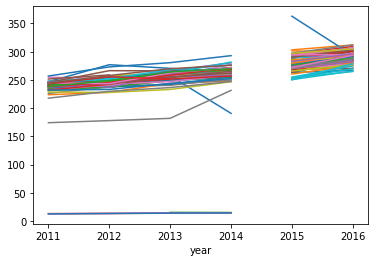

In [32]:
precios_year = spark.sql("SELECT DISTINCT municipio, producto, EXTRACT(YEAR FROM CAST(fechaRegistro AS DATE)) AS year, precio FROM preciosProfeco WHERE producto IN ('REFRESCO', 'DETERGENTE P/ROPA', 'FUD', 'LECHE ULTRAPASTEURIZADA', 'SHAMPOO', 'JABON DE TOCADOR', 'CHILES EN LATA', 'MAYONESA', 'YOGHURT', 'DESODORANTE')  ")
precios_year.createOrReplaceTempView("preciosyear")

precios_avg = spark.sql("SELECT DISTINCT municipio, year, AVG(precio) OVER (PARTITION BY municipio, producto, year) AS precio_max FROM preciosyear ORDER BY year")
precios_avg.createOrReplaceTempView("preciosAVGyear")

cambios_precios = spark.sql("SELECT DISTINCT municipio, year, SUM(precio_max) OVER (PARTITION BY municipio, year) AS compra_max FROM preciosAVGyear ")
cambios_precios = cambios_precios.to_koalas().to_pandas()
cambios_precios = cambios_precios.set_index('year')
cambios_precios.groupby('municipio')['compra_max'].plot()

## ¿Cuál es el estado más caro y en qué mes?

R: Sería Tamaulipas en febrero de 2015. Se hizo un promedio de precios de los 10 artículos de la canasta básica previamente descrita y se hizo analizó el precio máximo de compra (es decir solo se compra 1 refresco + 1 DETERGENTE P/ROPA + 1 FUD ...)

In [34]:
precios_edo = spark.sql("SELECT DISTINCT estado, producto, CONCAT(EXTRACT(YEAR FROM CAST(fechaRegistro AS DATE)) ,- EXTRACT(MONTH FROM CAST(fechaRegistro AS DATE)) ) AS year_month, precio FROM preciosProfeco WHERE producto IN ('REFRESCO', 'DETERGENTE P/ROPA', 'FUD', 'LECHE ULTRAPASTEURIZADA', 'SHAMPOO', 'JABON DE TOCADOR', 'CHILES EN LATA', 'MAYONESA', 'YOGHURT', 'DESODORANTE')")
precios_edo.createOrReplaceTempView("preciosEstado")

precios_avg_edo = spark.sql("SELECT DISTINCT estado, producto, year_month, AVG(precio) OVER (PARTITION BY estado, producto, year_month) AS avg_price FROM preciosEstado WHERE producto IN ('REFRESCO', 'DETERGENTE P/ROPA', 'FUD', 'LECHE ULTRAPASTEURIZADA', 'SHAMPOO', 'JABON DE TOCADOR', 'CHILES EN LATA', 'MAYONESA', 'YOGHURT', 'DESODORANTE') ORDER BY avg_price DESC")
precios_avg_edo.createOrReplaceTempView('avgPriceState')

edos_caros = spark.sql("SELECT DISTINCT estado, year_month, SUM(avg_price) OVER (PARTITION BY estado, year_month) AS avg_sale FROM avgPriceState ORDER BY avg_sale DESC")
edos_caros.show(10) 

+--------------+----------+------------------+
|        estado|year_month|          avg_sale|
+--------------+----------+------------------+
|    TAMAULIPAS|    2015-2|424.88435490826276|
|        OAXACA|   2015-11|324.48355258003966|
|       HIDALGO|    2015-7|  317.651849626566|
|       HIDALGO|    2015-8|311.22785305765495|
|        SONORA|    2016-4|  308.928460266357|
|       HIDALGO|    2015-4|308.34648318311713|
|       HIDALGO|    2015-5|  308.101539396339|
|       HIDALGO|    2015-9|307.44399100864706|
|AGUASCALIENTES|    2016-4| 307.4320000734386|
|       NAYARIT|    2016-3|307.38009653959824|
+--------------+----------+------------------+
only showing top 10 rows



## ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con estos datos?


R:  La principal consideración es de tener bien organizada la información y los datos de la columna temporal deben de estar depurados y corregidos para evitar omisión de datos (es decir, no podemos tener una fila con un registro como '2019-01-01' cuando la gran mayoría de los registros están como '2019-01-01 14:00:00'). También se deben de eliminar (si así lo requiere) valores extremos en los datos ya que pueden generar tendencias ficticias o cambios de nivel que no son ciertos. Por cuestiones de tiempo no pude realizar una depuración más a fondo .